# Silverkite Example (not done)
Silverkite is a model from the greykite package, developed by LinkedIn. It is considered an automated modeling procedure, like Facebook Prophet. It has its own database of holidays it forecasts with and attempts to tune its parameters automatically. The model itself is a type of linear regression with changepoints and regularization.  
In this notebook, the following concepts are covered:  
1. Loading Forecaster objects with external regressors  
2. Forecasting with default silverkite model  
3. Modifying changepoints in silverkite model  
4. Tuning silverkite model  
5. Model summaries  

- required package to download data: `!pip install pandas-datareader`  
- required package to run model: `!pip install greykite` (this is a big package)  
- read more about grekite: https://engineering.linkedin.com/blog/2021/greykite--a-flexible--intuitive--and-fast-forecasting-library  
- see the [combo](https://scalecast-examples.readthedocs.io/en/latest/combo/combo.html) notebook for an overview of this dataset with EDA  

In [1]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from scalecast.Forecaster import Forecaster

sns.set(rc={'figure.figsize':(12,8)})

In [2]:
df = pdr.get_data_fred(['HOUSTNSA','JHDUSRGDPBR'],start='1900-01-01',end='2021-12-31')
df['JHDUSRGDPBR'] = df['JHDUSRGDPBR'].fillna(method='ffill').fillna(0)
f = Forecaster(y=df['HOUSTNSA'],current_dates=df.index)
f

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2021-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=756
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

## Prepare Forecast

### Prepare the Recession Indicator
- use as an exogenous regressor

In [3]:
df.head()

,HOUSTNSA,JHDUSRGDPBR
DATE,,
1959-01-01,96.2,0.0
1959-02-01,99.0,0.0
1959-03-01,127.7,0.0
1959-04-01,150.8,0.0
1959-05-01,152.5,0.0


In [4]:
# prepare recession indicator for future
# assume no future recessions in next two years
recessions = df.reset_index()[['DATE','JHDUSRGDPBR']]
fut_recessions = pd.DataFrame({'DATE':pd.date_range(start=recessions['DATE'].max(),end=recessions['DATE'].max() + relativedelta(months=24),freq='MS').values[1:],
                              'JHDUSRGDPBR':[0]*24})
recessions = pd.concat([recessions,fut_recessions])
recessions.tail()

,DATE,JHDUSRGDPBR
19,2023-08-01,0.0
20,2023-09-01,0.0
21,2023-10-01,0.0
22,2023-11-01,0.0
23,2023-12-01,0.0


### Load Object with Parameters and Regressors
- Forecast length: 24 periods (two years)
- External recession indicator
- 1,000 bootstrap samples for more accurate confidence intervals

In [5]:
f.generate_future_dates(24)
f.set_test_length(.1)
f.ingest_Xvars_df(recessions,date_col="DATE")
f.set_bootstrap_samples(1000)
f

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2021-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=756
    ForecastLength=24
    Xvars=['JHDUSRGDPBR']
    Differenced=0
    TestLength=75
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=1000
    CurrentEstimator=None
)

## Apply the silverkite model

### Default parameters
- by default, silverkite will attempt to add its own seasonality, lags, and other model parameters
- in the underlying package, these parameters are validated with cross-validation, but in scalecast that feature is disabled for faster runtimes

In [6]:
f.set_estimator('silverkite')
f.manual_forecast(call_me='silverkite1')

After running this model, for some environments, it is necessary to reset some matplotlib parameters or else plots won't display.

In [7]:
matplotlib.use("nbAgg")
%matplotlib inline
sns.set(rc={'figure.figsize':(12,8)})

Now we can see the results on the test set.

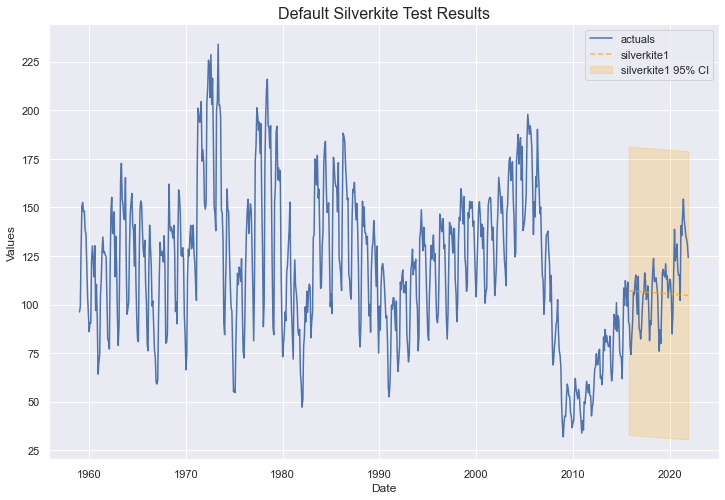

In [8]:
f.plot_test_set(ci=True,models='silverkite1')
plt.title('Default Silverkite Test Results',size=16)
plt.show()

### Adding Xvars and Changepoints

By default, this model did not pick up seasonality well at all. Let's try giving it the recession indicator to forecast with to see if that helps. We can also change the changepoints parameter to 5 as there appears to be about that many changes in the data's history.

In [9]:
f.manual_forecast(Xvars=['JHDUSRGDPBR'],changepoints=5,call_me='silverkite2')

In [10]:
matplotlib.use("nbAgg")
%matplotlib inline
sns.set(rc={'figure.figsize':(12,8)})

Now we can see the results on the test set.

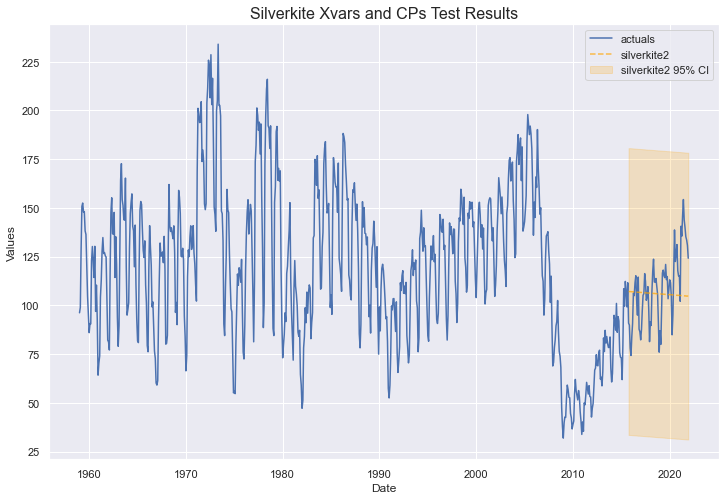

In [11]:
f.plot_test_set(ci=True,models='silverkite2')
plt.title('Silverkite Xvars and CPs Test Results',size=16)
plt.show()

## Tuning Hyperparameters

That didn't seem to make much if any difference on the dataset. We can try cycling through more changepoints to see if that helps. 

First, we set aside 12 validation periods to do that. Then, we create a grid that is of `dict` type, ingest the grid, tune the model with it on those 12 periods, and forecast with the best-performing selected hyperparameters. We change the validation metric to R2 to see if that helps it pick up more seasonality.

In [ ]:
f.set_validation_length(12)
f.set_validation_metric('r2')
grid = {'changepoints':range(7)}
f.ingest_grid(grid)
f.tune()
f.auto_forecast(call_me='silverkite3')

In [ ]:
matplotlib.use("nbAgg")
%matplotlib inline
sns.set(rc={'figure.figsize':(12,8)})

In [ ]:
f.plot_test_set(ci=True,models='silverkite3')
plt.title('Tuned Silverkite Test Results',size=16)
plt.show()

### Data Differencing

That didn't work as well as we were hoping, but we do have one last trick: forecasting on differenced data.

In [ ]:
f.diff() # raises an error if you run twice

In [ ]:
f.manual_forecast(call_me='silverkite4')

In [ ]:
matplotlib.use("nbAgg")
%matplotlib inline
sns.set(rc={'figure.figsize':(12,8)})

In [ ]:
f.plot_test_set(ci=True,models='silverkite4')
plt.title('Diffed Silverkite Test Results',size=16)
plt.show()

That gave us results on the differenced series, but, it is nice to always have results at the original forecast's level. Note that confidence intervals are no longer available when plotting a model that was forecasted on a differenced series at its original level.

In [ ]:
f.plot_test_set(models='silverkite4',level=True)
plt.title('Diffed Silverkite Test Results - Level',size=16)
plt.show()

## Model Summaries

It seems like that worked, at least as far as being able to capture seasonality. It is still not the best model for this series, but silverkite can work well for other series. We can now look at these models' forecasts to future periods. Note, all models are plotted at the original data level.

In [ ]:
f.plot()
plt.title('All models future forecasts')
plt.show()

Here is some error information about each model:

In [ ]:
pd.set_option('display.float_format',  '{:.4f}'.format)
ms = f.export('model_summaries',determine_best_by='LevelTestSetRMSE')
ms[
    [
        'ModelNickname',
        'LevelTestSetRMSE',
        'TestSetRMSE',
        'InSampleRMSE',
        'Xvars',
        'HyperParams'
    ]
]

Although our last model looked the most able to predict seasonality, it technically had worse out-of-sample RMSE than the other models. It did fit the underlying data the best, however, considering the InSampleRMSE.